In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import profanity_check
import nltk
nltk.download('stopwords')

import os

[nltk_data] Downloading package stopwords to /home/staver/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
DATA_DIR = 'data/'
QUOTEBANK_DATA_DIR = DATA_DIR + 'quotebank_data_raw/'

In [ ]:
speaker_attribs = pd.read_parquet(DATA_DIR + 'speaker_attributes.parquet', engine = 'fastparquet')
speaker_attribs = speaker_attribs.set_index('id')
attrib_labels = pd.read_csv('data/wikidata_labels_descriptions_quotebank.csv.bz2')
attrib_labels = attrib_labels.set_index("QID")

In [3]:
dfs = []
for i in os.listdir(QUOTEBANK_DATA_DIR):
    dfs.append(pd.read_json((QUOTEBANK_DATA_DIR + i), lines=True))
               
df = dfs[0]
if len(dfs) > 1:
    for df_part in dfs[1:]:
        df = df.union(df_part)

In [4]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2019-04-17-024782,"It is not a low-income immigration,",James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E
1,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E
2,2019-05-09-055187,It makes it much more difficult for him to mak...,None,[],2019-05-09 18:11:29,1,"[[None, 0.6493], [President Bill Clinton, 0.27...",[http://mobile.nytimes.com/2019/05/09/world/as...,E
3,2019-10-31-056366,"It puts me in a predicament,",Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E
4,2019-01-04-001792,A Pile of Leaves.,None,[],2019-01-04 10:00:07,1,"[[None, 0.8737], [Jason Fulford, 0.1263]]",[https://www.nytimes.com/2019/01/04/books/revi...,E


In [18]:
len(df[df.duplicated('quoteID')]) # 0 ~> no duplicate rows

0

## Exploring speakers

### Speaker frequency

In [5]:
speaker_freq = df['speaker'].value_counts()
speaker_freq.head(15)

None                      75582
President Donald Trump     2217
President Trump            1919
Elizabeth Warren            783
Joe Biden                   762
Bernie Sanders              562
Nancy Pelosi                560
Pete Buttigieg              549
Mike Pompeo                 469
Donald Trump                338
Bill de Blasio              335
Cory Booker                 312
Stephen Colbert             305
Mitch McConnell             265
Amy Klobuchar               259
Name: speaker, dtype: int64

We can notice a few problems: 
 - most quotes don't have an attributed speaker
 - same speaker can have multiple differing labels

In [6]:
speaker_freq[1:].describe() # without None

count    26579.000000
mean         4.964257
std         22.688574
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       2217.000000
Name: speaker, dtype: float64

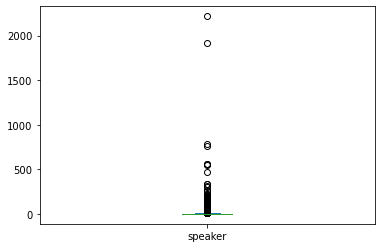

In [27]:
_ = speaker_freq[1:].plot(kind='box') # without None

### Speaker occupations

In [183]:
# Helper functions
def speaker_to_occupation(qid):
    """Return the label associated with a qid or None if not available."""
    if qid in speaker_attribs.index:
        return speaker_attribs.occupation[qid]
    return None

def qid_to_label(qid):
    """Return the label associated with a qid or None if not available."""
    if qid in attrib_labels.index:
        return attrib_labels.Label[qid]
    return None
    
def map_list(fn, values):
    if values is not None:
        return list(map(fn, values))
    return []

In [185]:
df_occupations = df.replace(to_replace='None', value=np.nan).dropna()
df_occupations["occupation"] = df_occupations.qids.apply(lambda val : speaker_to_occupation(val[0]))
df_occupations["occupation_labels"] = df_occupations.occupation.apply(lambda val : map_list(qid_to_label, val))

In [ ]:
df_occupations.head()

In [ ]:
# Helper
def freq_count(vals, counts):
    if vals is None: return
    for val in vals:
        if val not in counts: counts[val] = 0
        counts[val] += 1

In [ ]:
occupation_to_cnt = {}
df_occupations.occupation_labels.apply(lambda vals: freq_count(vals, occupation_to_cnt));
top10_occupations = sorted(occupation_to_cnt.items(), key=lambda x: x[1], reverse=True)[:10]

In [ ]:
plt.figure(figsize=(15,8))
_ = sns.barplot(x=[x for x,y in top10_occupations], y=[y for x,y in top10_occupations])

## Exploring Quotes

### Quotation length distribution

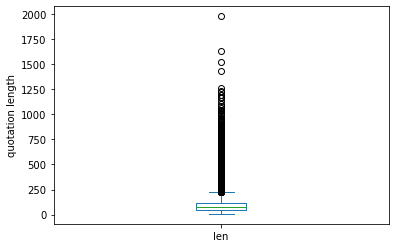

In [81]:
df['len'] = df['quotation'].apply(len) # Add quotation length feature
_ = df['len'].plot(kind='box', ylabel="quotation length", xlabel="quotation length") 

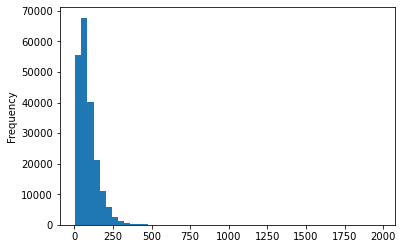

In [71]:
_ = df['len'].plot(kind='hist', bins=50, xlabel="quotation length")

### Most cited quotations

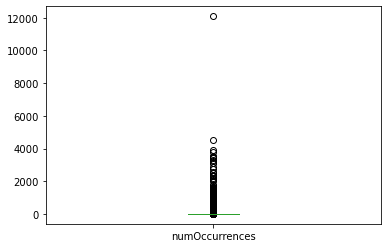

In [172]:
_ = df['numOccurrences'].plot(kind='box')

In [138]:
df.loc[df['numOccurrences'].argmax()] # Most cited quotation

quoteID                                           2019-04-12-080259
quotation                 Star... [ + ] Wars: The Rise of Skywalker
speaker                                                        None
qids                                                             []
date                                            2019-04-12 00:00:00
numOccurrences                                                12095
probas            [[None, 0.4952], [J.J. Abrams, 0.0752], [Daisy...
urls              [http://chronicle.northcoastnow.com/national-n...
phase                                                             E
profanity                                                  0.032646
len                                                              41
Name: 21764, dtype: object

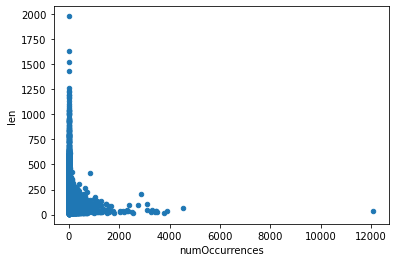

In [176]:
_ = df.plot(kind='scatter', x='numOccurrences', y='len') # Shorter quotes are more cited

## Exploring Profanity

In [40]:
df['profanity'] = profanity_check.predict_prob(df['quotation']) # Add profanity feature
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,profanity
0,2019-04-17-024782,"It is not a low-income immigration,",James Fisher,"[Q16213953, Q20707104, Q43143598, Q58886302, Q...",2019-04-17 13:31:18,1,"[[James Fisher, 0.7475], [None, 0.2525]]",[https://www.nytimes.com/2019/04/17/realestate...,E,0.017196
1,2019-04-02-001128,a champion figure skater switching to roller s...,John Updike,[Q105756],2019-04-02 14:58:33,2,"[[John Updike, 0.5856], [None, 0.4144]]",[https://www.nytimes.com/2019/04/02/opinion/vl...,E,0.012897
2,2019-05-09-055187,It makes it much more difficult for him to mak...,None,[],2019-05-09 18:11:29,1,"[[None, 0.6493], [President Bill Clinton, 0.27...",[http://mobile.nytimes.com/2019/05/09/world/as...,E,0.025312
3,2019-10-31-056366,"It puts me in a predicament,",Xavier Becerra,[Q1855840],2019-10-31 16:45:15,3,"[[Xavier Becerra, 0.9065], [None, 0.0909], [St...",[http://www.nytimes.com/2019/10/31/technology/...,E,0.046677
4,2019-01-04-001792,A Pile of Leaves.,None,[],2019-01-04 10:00:07,1,"[[None, 0.8737], [Jason Fulford, 0.1263]]",[https://www.nytimes.com/2019/01/04/books/revi...,E,0.125558


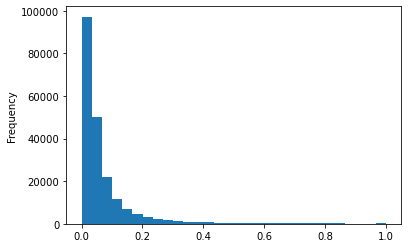

In [136]:
_ = df['profanity'].plot(kind='hist', bins=30, xlabel='profanity')

count    207527.000000
mean          0.071493
std           0.109267
min           0.000230
25%           0.017624
50%           0.036600
75%           0.076663
max           1.000000
Name: profanity, dtype: float64

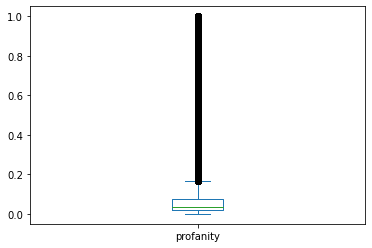

In [179]:
_ = df['profanity'].plot(kind='box')
df['profanity'].describe()

### High profanity quotations

In [134]:
threshold = 0.7
df_profane = df[df['profanity'] > threshold]
print(f"{len(df_profane)} quotes with profanity score > {threshold}")
df_profane.head()

1389 quotes with profanity score > 0.7


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,profanity,len
172,2019-01-10-120671,"You can put perfume on a pile of dung, and it ...",None,[],2019-01-10 00:54:59,2,"[[None, 0.876], [Michael Harrison, 0.0715], [M...",[http://www.nytimes.com/2019/01/09/us/baltimor...,E,0.747473,144
232,2019-09-21-039668,"Tell her to keep her mouth shut,",President Barack Obama,[Q76],2019-09-21 09:00:11,2,"[[President Barack Obama, 0.6097], [David Axel...",[http://www.nytimes.com/2019/09/21/us/politics...,E,0.975267,32
275,2019-07-05-076464,"We wanted to blow all that up,",Steven Wilson,[Q352766],2019-07-05 19:00:56,4,"[[Steven Wilson, 0.7926], [None, 0.2074]]",[http://mobile.nytimes.com/2019/07/05/nyregion...,E,0.743172,30
355,2019-09-19-033144,I find myself more concerned about the terribl...,None,[],2019-09-19 14:11:58,1,"[[None, 0.918], [President Trump, 0.082]]",[https://www.nytimes.com/2019/09/19/style/patt...,E,0.745001,210
362,2019-06-27-034157,"I think he was a racist,",Gabriel Sherman,[Q16210395],2019-06-27 18:00:46,1,"[[Gabriel Sherman, 0.8783], [None, 0.1044], [R...",[https://www.nytimes.com/2019/06/27/arts/telev...,E,0.813794,24


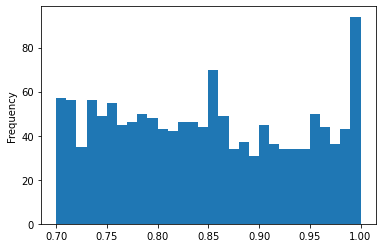

In [105]:
_ = df_profane['profanity'].plot(kind='hist', bins=30)

In [106]:
df_profane['speaker'].value_counts().head(15) # Speaker frequency in high profanity quotations

None                      570
President Donald Trump     37
President Trump            23
Joe Biden                  16
Elizabeth Warren            8
JIMMY KIMMEL                7
Bernie Sanders              6
Pete Buttigieg              5
Lindsey Graham              5
Kirsten Gillibrand          5
Javier Marías               4
Saeed Jones                 3
Bill de Blasio              3
STEPHEN COLBERT             3
Rodrigo Duterte             3
Name: speaker, dtype: int64

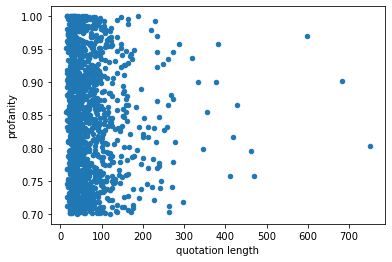

In [107]:
_ = df_profane.plot(kind='scatter', x='len', y='profanity', xlabel='quotation length') # No observable relationship

In [110]:
words = df_profane.quotation.str.split(expand=True).stack()
filtered_words = pd.Series(filter(lambda word: word.lower() not in stopwords.words(), words))

In [111]:
filtered_words.value_counts().head(20) # Most frequent words in high profanity quotations

I'm       99
like      99
going     73
--        63
kill      63
people    61
get       56
stupid    52
would     49
hate      48
hell      46
think     43
gay       39
like,     38
know      38
shut      36
black     35
got       34
white     33
racist    33
dtype: int64

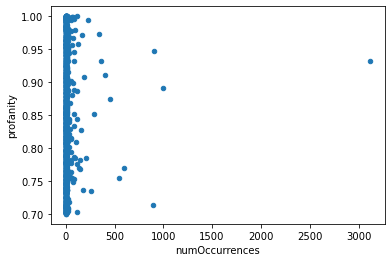

In [123]:
_ = df_profane.plot(kind='scatter', x='numOccurrences', y='profanity')

In [135]:
df_profane.iloc[df_profane['numOccurrences'].argmax()] # Most common high profanity quote

quoteID                                           2019-07-24-011721
quotation                disgusting, rat, and rodent infested mess.
speaker                                      President Donald Trump
qids                                                       [Q22686]
date                                            2019-07-24 21:11:30
numOccurrences                                                 3119
probas            [[President Donald Trump, 0.4486], [None, 0.22...
urls              [https://www.mitchellrepublic.com/news/nation/...
phase                                                             E
profanity                                                  0.931411
len                                                              42
Name: 186166, dtype: object

In [53]:
df.loc[df['profanity'].argmax()] # Highest profanity quote

quoteID                                           2019-06-21-021744
quotation                                         Fuck you, Sparky.
speaker                                                        None
qids                                                             []
date                                            2019-06-21 14:57:07
numOccurrences                                                    3
probas            [[None, 0.5406], [Jeremy Denk, 0.3325], [Errol...
urls              [http://www.nytimes.com/interactive/2019/06/21...
phase                                                             E
profanity                                                       1.0
Name: 37622, dtype: object

### Most profane speakers

In [161]:
df.groupby('speaker')['profanity'].mean().sort_values(ascending=False).head(10)

speaker
Lee Martin           0.993907
Kristin Cavallari    0.983488
Scott Alexander      0.970337
Elizabeth Levy       0.951503
Cady Huffman         0.943276
Nic Pizzolatto       0.940754
Ed Dwight            0.928452
Joshua Rush          0.923477
William Buckley      0.922743
Will Young           0.918782
Name: profanity, dtype: float64

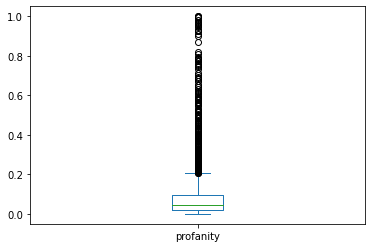

In [171]:
df_trump = df[df['speaker'] == ('President Donald Trump' or 'Donald Trump' or 'President Trump')]
_ = df_trump['profanity'].plot(kind='box') # Trump profanity distribution

### Most profane occupations

In [ ]:
# Helper
def append_to_list(vals, profanity, counts):
    if vals is None: return
    for val in vals:
        if val not in counts: counts[val] = []
        counts[val].append(profanity)

In [ ]:
occupation_to_profanity_list = {}
df_occupations['profanity'] = profanity_check.predict_prob(df_occupations['quotation']) # Add profanity feature
df_occupations.apply(lambda row: append_to_list(row['occupation_labels'], row['profanity'], occupation_to_profanity_list), axis=1)

In [ ]:
occupation_to_profanity = {k: np.mean(v) for k, v in occupation_to_profanity_list.iteritems()}

In [ ]:
top10_by_profanity = sorted(occupation_to_profanity.items(), key=lambda x: x[1], reverse=True)[:10]
plt.figure(figsize=(15,8))
_ = sns.barplot(x=[x for x,y in top10_by_profanity], y=[y for x,y in top10_by_profanity])

### Profanity through time

TODO: Add Dewmini's plots